In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
from galpy.df import streamdf,streamgapdf  
import streamspraydf
from galpy.util import bovy_coords, bovy_conversion
import pal5_util
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import streampepperdf

In [ ]:
from galpy.df import streamdf

In [2]:
#import streamspraydf
#from importlib import reload
#reload(streamspraydf)

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

In [3]:
#setup the bar

#Compute normalization rho_0

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6

Mbar=10**10 #Msun, half of what Wang is using, same as Pearson


def rho1(R,z):
    return (2.*np.pi*x0*y0)*R*np.exp(-0.5*(np.sqrt(R**4 + (z/z0)**4)))

rho1norm= integrate.nquad(rho1,[[0,np.inf],[-np.inf,np.inf]])[0]

def rho2(R):
    return (z0**1.85 *4.*np.pi/q**2)*R**(0.15)*np.exp(-R/z0)

rho2norm= integrate.quad(rho2,0,np.inf)[0]
rho0=Mbar/(rho1norm + rho2norm)

def r1c(R,z,p):
    return ((R**4.)*(np.cos(p)**2./x0**2 + np.sin(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return rho0*(np.exp((-r1c(R,z,p)**2.)/2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z)))


def initial_angle(pat_speed,t_age_Gyr=5.,fin_phi_deg=27.):
    
    kpc_to_km= 1000.*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
    init_phi= fin_phi - o_p*(t_age_Gyr*Gyr_to_s)
    return init_phi

n=9
l=19

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        N=n+1,L=l+1,a=1./ro,radial_order=40,costheta_order=40,phi_order=40)



def MWPotentialSCFbar(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,fin_phi=27.,t_age_Gyr=9.):
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    init_ang=initial_angle(pat_speed=pat_speed,t_age_Gyr=t_age_Gyr,fin_phi_deg=fin_phi)
    
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=init_ang)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    return (MWP2014SCFbar,MWP2014SCFnobar)

/home/nil/anaconda3/lib/python3.6/site-packages/galpy/potential/SCFPotential.py:857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  s+= nu.prod(wp[index])*integrand(*xp[index])



In [4]:
Mbar=10**10.
pat_speed=40.
ang=27.
barpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi=ang)[0]
nobarpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi=ang)[1]

[  0.           0.14062292   0.28124585 ... 140.34167685 140.48229977
 140.62292269]


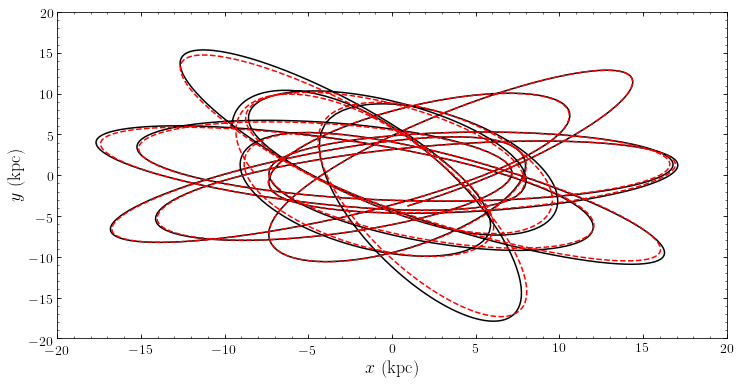

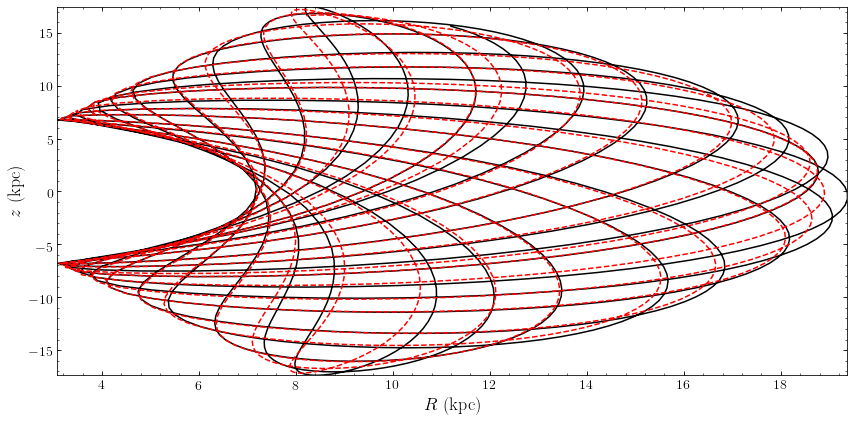

In [5]:
tpal5=numpy.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(220.,8.)

print (tpal5)
pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5.integrate(tpal5,nobarpot)



p5bar=Orbit(pal5(tpal5[-1]).flip()._orb.vxvv,ro=ro,vo=vo)
p5nobar=Orbit(pal5(tpal5[-1]).flip()._orb.vxvv,ro=ro,vo=vo)

p5bar.integrate(tpal5,barpot)
p5nobar.integrate(tpal5,nobarpot)

#p5cbar=p5bar(tpal5[-1])._orb.vxvv
#p5cnobar=p5nobar(tpal5[-1])._orb.vxvv

#print (p5cbar, p5cnobar)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)

p5bar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='k')
p5nobar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='r',ls='--',overplot=True)



p5bar.plot(c='k')
p5nobar.plot(c='r',ls='--',overplot=True)

tight_layout()


In [6]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
#sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)

#Sample N points from the smooth model today 
N=10
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
#Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

In [ ]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like


orbitst= []
orbitsl= []

#N=500
finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

pfinalRt= numpy.empty(N)
pfinalphit= numpy.empty(N)
pfinalzt= numpy.empty(N)



finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

lt_p1=numpy.empty(N)
bt_p1=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)


for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    ot.integrate(tst,nobarpot)
    orbitst.append(ot(tst[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below
    unp_orb = ot(tst[-1]).flip()._orb.vxvv #vxvv for particle at the time of stripping
    #print (unp_orb)
    
    #same progenitor, different names, just for easy tracking
    pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
    
    pal5_nobar.integrate(tst,nobarpot)
    pal5_bar.integrate(tst,barpot)
    
    #flip again to get correct velocity of the progenitor
    prog_orb_nobar=pal5_nobar(tst[-1]).flip()._orb.vxvv
    prog_orb_bar=pal5_bar(tst[-1]).flip()._orb.vxvv
    
    #print (prog_orb_nobar)
    #print (prog_orb_bar)
    
    pert_orb=(np.array(unp_orb) - np.array(prog_orb_nobar)) + np.array(prog_orb_bar)
    pert_orb=list(pert_orb)
    #print (pert_orb)
    
    p_orb=Orbit(pert_orb)
    
    p_orb.integrate(tst,barpot)
    pfinalRt[ii]= p_orb.R(tst[-1])
    pfinalphit[ii]= p_orb.phi(tst[-1])
    pfinalzt[ii]= p_orb.z(tst[-1])
    
    orbitst[ii].integrate(tst,barpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(pfinalRt[ii],pfinalphit[ii],pfinalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(pfinalRt[ii],pfinalphit[ii],pfinalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True) 
    
    
    
    
    
    
    #leading   
    #ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    #tsl= numpy.linspace(0.,dtl[ii],1001)
    #ol.integrate(tsl,nobarpot)
    #orbitsl.append(ol(tsl[-1]).flip())  # get the orbit at the final time step, flip the velocities for forward integration below
        

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Perturbed Pal5')

plt.scatter(radecpt[:,0],radecpt[:,1],s=2)

plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(225.,291.)
#plt.ylim(-0.5,9.5)



plt.subplot(1, 2, 2)
plt.title('Unperturbed Pal5')

plt.scatter(radecpt1[:,0],radecpt1[:,1],s=2,c='k')

plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

tight_layout()

plt.show()


In [ ]:
#Pal 5 progenitor today
pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 

#for a given stripping time, integrate Pal 5 progenitor's orbit backward for that time in nobarpot and bar pot

t_age=5./bovy_conversion.time_in_Gyr(vo,ro)

tt= numpy.linspace(0.,t_age,1001)

print (tt)

pal5_nobar.integrate(tt,nobarpot)
pal5_bar.integrate(tt,barpot)



bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)

pal5_nobar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='k')
pal5_bar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='r',overplot=True)



pal5_nobar.plot(c='k')
pal5_bar.plot(c='r',overplot=True)

tight_layout()

In [ ]:
#pal5_nobar.animate(c='k')
pal5_bar.animate(c='r',overplot=True)